In [1]:
import torch

In [2]:
import numpy as np
import csv
import random
import math
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

#import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torch.optim as optim
from torch import utils
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(1)
CUDA_LAUNCH_BLOCKING=1
#torch.autograd.set_detect_anomaly(True)
print (use_cuda)

torch.backends.cudnn.enabled
import os

import sigopt
import time


True


In [3]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.db import connect


from clease.tools import update_db
from clease import Concentration
from clease import CEBulk
from clease import Evaluate
from clease import NewStructures
from clease.calculator import Clease
from clease.calculator import attach_calculator

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

import json
with open('agpd_dft_eci_final_submission.json') as json_file: 
    eci = json.load(json_file) 
    
conc = Concentration(basis_elements=[['Ag', 'Pd']])
settings = CEBulk(crystalstructure='fcc',
                   a=4.09,
                   size=[3,3,3],
                   concentration=conc,
                   db_name="agpd_dft_ref_final_submission.db",
                   max_cluster_size=4,
                   max_cluster_dia=[8.0, 6.5, 5.5])

atoms = settings.atoms.copy()
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

gmeans = np.linspace(0,1,51)
gmeans_ten = torch.tensor(gmeans).cuda()

k_b = 0.00008617

def get_concentrations(lattices):
    lattices = ((lattices+1)/2).view(lattices.shape[0],-1)
    Ag_conc = torch.sum(lattices,dim=1)/(Dim*Dim*Dim)
    return Ag_conc

/home/james/miniconda3/envs/james_mlmat/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: convert_string_to_fd does not facilitate proper resource management.  Please use e.g. ase.utils.IOContext class instead.
  warnings.warn(warning)
/home/james/miniconda3/envs/james_mlmat/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


In [4]:
###### Based off Wu et Al. Solving Statistical Mechanics Using Variational Autoregressive Networks


def KL_loss(DBG,lattices,epoch,temp,field,num_temps,num_fields):
    lattices = lattices.detach()
    probs = DBG.get_sample_prob(lattices,temp,field,epoch).view(lattices.shape[0])
    with torch.no_grad():
        energies = DBG.get_energies(lattices).view(lattices.shape[0])
        energies_norm = energies.view(-1)/(temp.view(-1)*k_b)
       
        F = (energies_norm + probs).view(-1,1)
        F_new = F - (field.view(-1,1) * lattices.view(-1,DBG.Nz).sum(dim=1).view(-1,1))/(k_b*temp.view(-1,1))
        
        batch = int(lattices.shape[0]/(num_temps*num_fields))
        F_mean = F_new.view(-1,num_fields).view(num_temps,-1,num_fields)
        
        F_mean = F_mean.mean(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        R = (F_new.view(-1) - F_mean.reshape(-1))/torch.abs(F_mean.reshape(-1))
        
    #print(energies_norm.mean())
    assert not R.requires_grad
    assert probs.requires_grad
    return torch.mean(R*probs)

In [5]:
temps_sim = [200,375,550,725,900]
field_sim = [-0.2,-0.1,0.0,0.1,0.2]
temp_temp = [0]
field_temp = [0]
coordinate_cutoff = 4.0
def train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range):
    field_sim = [-0.2,-0.1,0.0,0.1,0.2]
    if temp_range == 'Large':
        temps_sim = [100,300,500,700,900]
    else:
        temps_sim = [200,375,550,725,900]
    epoch = 0
    temp = torch.zeros(len(temps_sim)*batch_size).cuda()
    field = torch.zeros(len(temps_sim)*batch_size).cuda()

    print_log_header()

    while epoch < epochs:
        if temp_type == 'Random Single':
            num_temps = 1
            t = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t
        elif temp_type == 'Random':
            t_fixed = []
            for i in range(5):
                t_temp = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
                t_fixed.append(t_temp)
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t_fixed[int(i/batch_size)]
        else:
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = temps_sim[int(i/batch_size)]
            
        if chem_type == 'Random Single':
            num_fields = 1
            f = -0.2 * 0.4*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                field[i] = f
        elif chem_type == 'Random':
            f_fixed = []
            for i in range(5):
                f_temp = -0.2 * 0.4*np.random.rand()
                f_fixed.append(f_temp)
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = f_fixed[int(i%(len(field_sim)))]
        else:
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = field_sim[int(i%(len(field_sim)))]
        
        
        epoch = epoch + 1

        lattices = model.forward(temp,field)
        
        
        kl_loss = KL_loss(model,lattices,epoch,temp,field,num_temps,num_fields)
        
        optimizer.zero_grad()
        kl_loss.backward()
        optimizer.step()
            
       
    return model

In [6]:
def print_log_header():
    print ('{:>8} {:>12}'\
       .format('epoch','train loss'))
    
def print_training_log(epoch, train_loss, test_loss=None):
    if test_loss is not None:
        print ('{:>8} {:>8} {:>12.4f} {:>12.4f}'\
                   .format(epoch, train_loss, test_loss))
        f.write('{:>8} {:>8} {:>12.4f} {:>12.4f}\n'\
                   .format(epoch, train_loss, test_loss))
    else:
        print ('{:>8} {:>8}'\
                   .format(epoch, train_loss))

In [7]:
def one_hot_to_sites(lattices,Nz):
    lattices = lattices.view(-1,Nz,2)
    lattices = torch.argmax(lattices,dim=2)
    lattices = 2*lattices - 1.0
    lattices = lattices.view(-1,Nz)
    return lattices.float()
    
def sites_to_one_hot(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    lattices = (0.5*(lattices + 1)).long()
    one_hot_lattices = torch.zeros(lattices.shape[0],lattices.shape[1],2).float().cuda()
    one_hot_lattices = one_hot_lattices.scatter_(2,lattices.view(lattices.shape[0],-1,1),1.0)
    return one_hot_lattices.detach()

In [8]:
def mask_weight(m,disp):
    num_sites = m.shape[1]
    num_components = 2
    mask = torch.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if (disp == 0):
                if (j == 0 or j == 1 ):
                    mask[i,j] = 1.0
                elif ((j-2) < num_components*int(i/num_components) ):
                    mask[i,j] = 1.0
            if (disp == 1):
                if (j == 0 or j==1 ):
                    mask[i,j] = 1.0
                if ((j-2) < num_components*int(i/num_components) + num_components):
                    mask[i,j] = 1.0
    mask = mask.detach()
    m_masked = m*mask
    return m_masked

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [9]:
class autoreg_model(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignments = assignments
        self.activation = activation_functions[assignments['activation']]
        self.lsoftmax = torch.nn.LogSoftmax(dim=2)
        self.softmax = torch.nn.Softmax(dim=2)
        self.num_layers = int(assignments['Layers'])
        self.shared_layer = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer.weight,0))
        self.mask_1 = mask_weight(torch.ones_like(self.shared_layer.weight),0).cuda()
        self.shared_layer.weight.register_hook(get_zero_grad_hook(self.mask_1))
        
        self.shared_layer_2 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_2.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_2.weight,1))
        self.mask_2 = mask_weight(torch.ones_like(self.shared_layer_2.weight),1).cuda()
        self.shared_layer_2.weight.register_hook(get_zero_grad_hook(self.mask_2))
        
        self.shared_layer_3 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_3.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_3.weight,1))
        self.mask_3 = mask_weight(torch.ones_like(self.shared_layer_3.weight),1).cuda()
        self.shared_layer_3.weight.register_hook(get_zero_grad_hook(self.mask_3))
        
        self.shared_layer_4 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_4.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_4.weight,1))
        self.mask_4 = mask_weight(torch.ones_like(self.shared_layer_4.weight),1).cuda()
        self.shared_layer_4.weight.register_hook(get_zero_grad_hook(self.mask_4))
        
    def get_sample_prob(self,lattices,temp,field,epoch):
        #print(self.shared_layer.weight)
        
        batch_size = temp.shape[0]
        samples = sites_to_one_hot(lattices).view(batch_size,-1)
        net_in = torch.cat((field.view(-1,1)*10,samples),dim=1)
        net_in = torch.cat((temp.view(-1,1)/1000,net_in),dim=1)
        conditional = self.activation(self.shared_layer(net_in))
        conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
        conditional = self.shared_layer_2(conditional)
        if self.num_layers > 2:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_3(conditional)
            
        if self.num_layers > 3:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_4(conditional)
        
        conditional = conditional.view(-1,self.Nz,2)
        Probs = self.lsoftmax(conditional)
        samples = samples.detach()
        #assert sample.requires_grad == False
        assert Probs.requires_grad == True
        site_prob = Probs*(samples.view(-1,self.Nz,2))
        probs = torch.sum(torch.sum(site_prob,dim=2),dim=1)
        return probs
        
    def forward(self,temp,field):
        
        batch_size = temp.shape[0]
        temp = temp.view(-1,1)
        field = field.view(-1,1)
        lattices = torch.zeros(batch_size,2*self.Nz).cuda()
        for site in range(self.Nz):
            net_in = torch.cat((field*10,lattices),dim=1)
            net_in = torch.cat((temp/1000,net_in),dim=1)
            conditional = self.activation(self.shared_layer(net_in))
            conditional = torch.cat((field*10,conditional),dim=1)
            conditional = torch.cat((temp/1000,conditional),dim=1)
            conditional = self.shared_layer_2(conditional)
            if self.num_layers > 2:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_3(conditional)
            
            if self.num_layers > 3:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_4(conditional)
            
            conditional = conditional.view(-1,self.Nz,2)
            Probs = self.softmax(conditional)
            To_Sample = Probs[:,site,:]
            sample = torch.multinomial(To_Sample,1).view(-1,1)
            lattices = lattices.view(-1,self.Nz,2)
            lattices[:,site,:] = lattices[:,site,:].scatter_(1,sample,1)
            lattices = lattices.view(-1,2*self.Nz)
        #print(lattices.requires_grad)
        lattices = one_hot_to_sites(lattices,self.Nz)
        return lattices

def create_model(Nz,assignments):
    class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            atoms.numbers = np.ones((self.Nz))*46
            self.U_pd = atoms.get_potential_energy()
            atoms.numbers = np.ones((self.Nz))*47
            self.U_ag = atoms.get_potential_energy()
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            lattices = lattices.view(lattices.shape[0],-1)
            energies = torch.zeros(lattices.shape[0]).cuda()
            for lattice_num in range(lattices.shape[0]):
                energies[lattice_num] = self.get_cluster_energy(lattices[lattice_num,:])
            #print(energies)
            return energies
        
        def get_cluster_energy(self,lattice):
            atoms.numbers = (((lattice + 1)/2)*1 + 46).int().cpu().detach().numpy()
            energy_t = atoms.get_potential_energy()
            return energy_t
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)
        
    model = Discrete_Boltzmann_Generator(Nz,assignments).cuda()
    temp_range = assignments['temp_range']
    batch_size = int(assignments['batch_size'])
    optimizer = optimizers[assignments['optimizer']](model.parameters(), lr=10**assignments['log_learning_rate'])
    epochs = assignments['epochs']
    temp_type = assignments['temp_type']
    chem_type = assignments['Chem_type']
    model = train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range)
    
    return model

In [10]:
class Discrete_Boltzmann_Generator(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignment = assignments
        self.Model = autoreg_model(Nz,assignments)
        atoms.numbers = np.ones((self.Nz))*46
        self.U_pd = atoms.get_potential_energy()
        atoms.numbers = np.ones((self.Nz))*47
        self.U_ag = atoms.get_potential_energy()
            
    def forward(self,temp,field):
        return self.Model.forward(temp,field)
            
    def get_energies(self,lattices):
        lattices = lattices.view(lattices.shape[0],-1)
        energies = torch.zeros(lattices.shape[0]).cuda()
        for lattice_num in range(lattices.shape[0]):
            energies[lattice_num] = self.get_cluster_energy(lattices[lattice_num,:])
            
        return energies
        
    def get_cluster_energy(self,lattice):
        atoms.numbers = (((lattice + 1)/2)*1 + 46).int().cpu().detach().numpy()
        energy_t = atoms.get_potential_energy()
        return energy_t
        
    def get_sample_prob(self,sample,temp,field,epoch):
        return self.Model.get_sample_prob(sample,temp,field,epoch)
        

In [11]:
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh(),
}

optimizers = {
    'gradient_descent': optim.SGD,
    'rmsprop': optim.RMSprop,
    'adam': optim.Adam,
}


Dim = 3

In [12]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,27)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(tmp*k_b)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(tmp*k_b)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    rw = torch.exp(log_rw)
    
    Ness = torch.sum(rw)**2 / torch.sum(rw**2)
    return Ness

In [13]:
from sigopt import Connection
import socket

#conn = Connection(client_token="RAFA GB TOKEN")
experiment_id = 357554
hostname = socket.gethostname()
experiment = conn.experiments(experiment_id).fetch()
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments

NameError: name 'conn' is not defined

In [13]:
assignments = {
  "Chem_type": "Fixed",
  "Layers": "3",
  "activation": "sigmoid",
  "batch_size": "250",
  "epochs": 17228.762093926078,
  "log_learning_rate": -2.524528017542186,
  "optimizer": "adam",
  "temp_range": "Small",
  "temp_type": "Random"
}

In [ ]:
import time

start = time.time()

model = create_model(27,assignments)

end = time.time()

   epoch   train loss


In [20]:
print((end-start)/3600)

17.693254825870195


In [ ]:
print(model.state_dict())

In [21]:
torch.save(model.state_dict(), "AgPdCE_small_model_final_submission")

In [ ]:
def get_Ness(model,lattices,tmp,temp_b,field_b):
    size = lattices.shape[0]
    iters = int(size/1000)
    lattices = lattices.view(-1,iters,27)
    for i in range(iters):
        energies = (model.get_energies(lattices[:,i,:])/(k_b*tmp)).view(-1)
        prob = model.get_sample_prob(lattices[:,i,:],temp_b,field_b,1000).view(-1)
        temp_pot = -(field_b.view(-1)*lattices[:,i,:].sum(dim=1).view(-1))/(k_b*tmp)
        temp_pot = energies+prob+temp_pot
        if i ==0:
            pot = temp_pot
        else:
            pot = torch.cat((pot,temp_pot),dim=0)
    log_rw = -pot
    log_rw = log_rw - log_rw.mean()
    
    
    log_rw = log_rw.view(-1)
    Top_term = 2*torch.logsumexp(log_rw,dim=0)
    Bottom_term = torch.logsumexp(2*log_rw,dim=0)
    Log_Ness = Top_term - Bottom_term
    return torch.exp(Log_Ness)

In [ ]:
chem_p = np.linspace(-0.2,0.2,40)
temps = np.linspace(200,900,20)
num = 10000
temps_f = torch.zeros(1000).cuda()
ch_p_f = torch.zeros(1000).cuda()
Ness = np.zeros((temps.shape[0],chem_p.shape[0]))
for i in range(temps.shape[0]):
    for j in range(chem_p.shape[0]):
        for m in range(10):
            for k in range(1000):
                temps_f[k] = temps[i]
                ch_p_f[k] = chem_p[j]
            temp_lattices = model.forward(temps_f,ch_p_f)
            if m ==0:
                lattices = temp_lattices
            else:
                lattices = torch.cat((lattices,temp_lattices),dim=0)
        
        N_temp = get_Ness(model,lattices,temps[i],temps_f,ch_p_f)
        Ness[i,j] = N_temp/num


In [88]:
print(Ness.shape)

(20, 40)


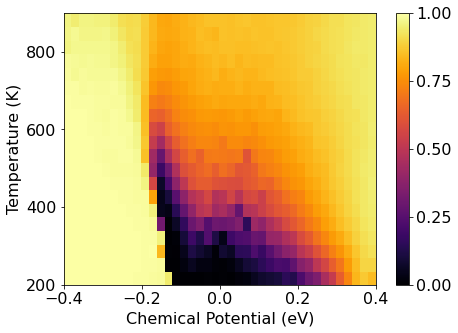

In [23]:
all_chem_p = []
all_temps = []
for i in range(temps.shape[0]):
    for j in range(chem_p.shape[0]):
        all_temps.append(temps[i])
        all_chem_p.append(2*chem_p[j])

import matplotlib as mpl
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial',"fontsize":16}

plt.hist2d(all_chem_p,all_temps,bins = (40,20), weights = Ness.reshape(-1),cmap='inferno',vmin=0.0,vmax=1.0)
plt.rcParams["figure.figsize"] = (7,5)
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname = "Arial")
plt.ylabel('Temperature (K)',fontsize=16,fontname = "Arial")
plt.yticks(fontsize=16,fontname = "Arial")
plt.xticks(fontsize=16,fontname = "Arial")
plt.yticks([200,400,600,800])
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
cb = plt.colorbar()
imaxes = plt.gca()
plt.axes(cb.ax)
cb.ax.tick_params(labelsize=16)
cb.set_ticks([0.0,0.25,0.50,0.75,1.0])
plt.savefig("NESS_AGPD_CE_27_FinalSubmission.pdf",bbox_inches='tight')

In [25]:
def examine_phase(model,lattices,tmp,temp_b,field_b,Ag_conc):
    #print(lattices)
    prob = model.get_sample_prob(lattices,temp_b,field_b,1000).view(-1)
    with torch.no_grad():
        energies = (model.get_energies(lattices)/(tmp*k_b)).view(-1)
        
        pot = -(field_b.view(-1)*lattices.sum(dim=1).view(-1))/(tmp*k_b)
        pot = energies+prob+pot
        log_rw = -pot
        stored = log_rw.mean()
        log_rw_corr = log_rw - stored
        rw = torch.exp(log_rw_corr)
        rw_norm = rw/(rw.sum())
        est_part = torch.exp(log_rw_corr).mean()
        log_z = torch.log(est_part)+stored
        conc_mean = (Ag_conc.view(-1)*rw_norm.view(-1)).sum().cpu().detach().numpy().item()

        gp = -k_b*tmp*log_z
        
        
    return conc_mean,gp

In [26]:
def get_conc_at_temp(temp):
    
    chemical_pots = np.linspace(-0.2,0.2,41)
    concs_rw = np.linspace(-.2,.2,41)
    gps = np.linspace(-.2,.2,41)
    temps = torch.zeros(10000).cuda()
    counter = 0
    for chpot in chemical_pots:
        temps = torch.zeros(10000).cuda()
        fields = torch.zeros(10000).cuda()
        for i in range(10000):
            temps[i] = temp
            fields[i] = chpot
            
        lattices = model.forward(temps,fields)
        concs_iter = get_concentrations(lattices).view(-1)
        
        conc_mean,gp = examine_phase(model,lattices,temp,temps,fields,concs_iter)
        gps[counter] = gp.cpu().detach().numpy()
        concs_rw[counter] = conc_mean
        counter = counter + 1
        
    return chemical_pots,concs_rw,gps

In [27]:
concs_sim_np = np.loadtxt(open("AgPdDFT_ref_SGC_3_concs_final_submission_np.csv", "rb"), delimiter=",", skiprows=0)


In [33]:
chemical_pots_low,concs_rw_low,gps_low = get_conc_at_temp(250)
chemical_pots_high,concs_rw_high,gps_high = get_conc_at_temp(750)

In [34]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


In [35]:
color = newcmp(1.0)
print(matplotlib.colors.rgb2hex(color))
color = newcmp(0.66666)
print(matplotlib.colors.rgb2hex(color))
color = newcmp(0.333333)
print(matplotlib.colors.rgb2hex(color))
color = newcmp(0.0)
print(matplotlib.colors.rgb2hex(color))

#ffa600
#e95d71
#79508e
#003f5c


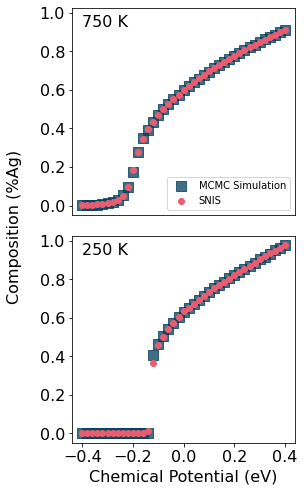

In [37]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})
import matplotlib as mpl
import matplotlib.font_manager as font_manager


mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
axs[0].scatter(chemical_pots_low*2.0,np.flip(concs_sim_np[:,1]),color=newcmp(0.0),label='MCMC Simulation',alpha=0.75,s = 100,marker='s')
axs[0].scatter(chemical_pots_low*2.0,concs_rw_high,color=newcmp(0.66666),label='SNIS',alpha=1.0)
axs[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].tick_params(labelsize=16)
prop = font = font_manager.FontProperties(family='Arial',size=10)
axs[0].legend(loc = 4,prop=font)
axs[0].text(-0.4, 0.95, '750 K', fontsize = 16,fontname = "Arial",va='center', rotation='horizontal')


axs[1].scatter(chemical_pots_low*2.0,np.flip(concs_sim_np[:,0]),color=newcmp(0.0),alpha=0.75,s = 100,marker='s')
axs[1].scatter(chemical_pots_low*2.0,concs_rw_low,color=newcmp(0.6666666),alpha=1.0)
axs[1].text(-0.4, 0.95, '250 K', fontsize = 16,fontname = "Arial",va='center', rotation='horizontal')

axs[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axs[1].tick_params(labelsize=16)

plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname = "Arial")
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
#fig.ylabel('Prob.',fontsize=14,**hfont)
fig.text(-0.1, 0.5, 'Composition (%Ag)', fontsize = 16,fontname = "Arial",va='center', rotation='vertical')
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.rcParams["figure.figsize"] = (4,8)
plt.savefig('ag_pd_concs_Final_Submission.pdf',bbox_inches='tight')

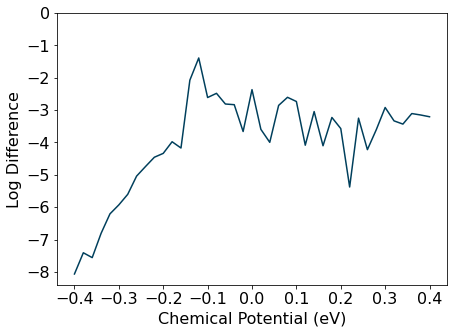

In [39]:

plt.plot(chemical_pots_low*2.0,np.log10(abs(concs_rw_low-np.flip(concs_sim_np[:,0]))),color=newcmp(0.0))

plt.rcParams["figure.figsize"] = (7,5)
mpl.rc('font',family='Arial')
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
plt.yticks([0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6,-7,-8])
plt.ylabel('Log Difference',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.savefig('AgPdError1_Final_Submission.pdf',bbox_inches='tight')
    
plt.show()

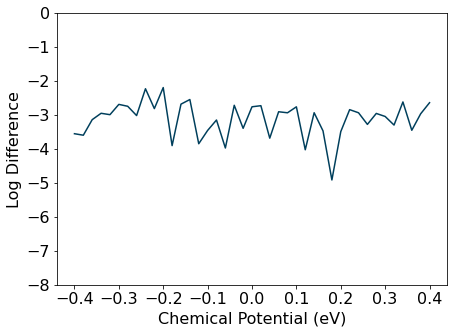

In [40]:
plt.plot(chemical_pots_low*2.0,np.log10(abs(concs_rw_high-np.flip(concs_sim_np[:,1]))),color=newcmp(0.0))

plt.rcParams["figure.figsize"] = (7,5)
mpl.rc('font',family='Arial')
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
plt.yticks([0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6,-7,-8])
plt.ylabel('Log Difference',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.savefig('AgPdError2_Final_Submission.pdf',bbox_inches='tight')
    
plt.show()

In [41]:
from ase.io import write


In [132]:
print(ase.__version__)

3.19.1


In [43]:
########## AgPd Crystal

#from ase.io.png import write_png

tmp = 250.
field = -0.08
tmps = torch.zeros(1000).cuda()
fields = torch.zeros(1000).cuda()
for i in range(1000):
    tmps[i] = tmp
    fields[i] = field
    
lats = model.forward(tmps,fields)
energies = model.get_energies(lats)
min_index = -1
min_energy = 9999999
for i in range(1000):
    curr_energy = energies[i]
    if curr_energy < min_energy:
        min_energy = curr_energy
        min_index = i

print(min_index)
lat = lats[50,:]


atoms.numbers = ((((lat + 1)/2)*1 + 46).int().cpu().detach().numpy()).reshape(-1)
print(atoms.numbers)
print(atoms)

write('test_08_final_submission.png',atoms,format='png')

951
[46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46]
Atoms(symbols='Pd27', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))


In [44]:
np.save('AgPd_27_Ce_NESS_Final_submission.npy', Ness) 


In [45]:
np.save('AgPd_27_Ce_250K_Final_submission.npy', concs_rw_low) 


In [46]:
np.save('AgPd_27_Ce_750K_Final_submission.npy', concs_rw_high) 
